# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [3]:
raw_data = pd.read_csv('/content/drive/My Drive/Loan_Repayment_Cleaned.csv')
raw_data.head()

,Unnamed: 0,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,loan_repaid,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,initial_list_status_w,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,OTHER,OWN,RENT,05113,11650,22690,29597,30723,48052,70466,86630,93700
0,0,10000.0,36,11.44,329.48,117000.0,26.24,1990,16.0,0.0,36369.0,41.8,25.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
1,1,8000.0,36,11.99,265.68,65000.0,22.05,2004,17.0,0.0,20131.0,53.3,27.0,3.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,15600.0,36,10.49,506.97,43057.0,12.79,2007,13.0,0.0,11987.0,92.2,26.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,3,7200.0,36,6.49,220.65,54000.0,2.60,2006,6.0,0.0,5472.0,21.5,13.0,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,4,24375.0,60,17.27,609.33,55000.0,33.95,1999,13.0,0.0,24584.0,69.8,43.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [4]:
data = raw_data.drop('Unnamed: 0', axis = 1)

data.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,loan_repaid,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,initial_list_status_w,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,OTHER,OWN,RENT,05113,11650,22690,29597,30723,48052,70466,86630,93700
0,10000.0,36,11.44,329.48,117000.0,26.24,1990,16.0,0.0,36369.0,41.8,25.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
1,8000.0,36,11.99,265.68,65000.0,22.05,2004,17.0,0.0,20131.0,53.3,27.0,3.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,15600.0,36,10.49,506.97,43057.0,12.79,2007,13.0,0.0,11987.0,92.2,26.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,7200.0,36,6.49,220.65,54000.0,2.60,2006,6.0,0.0,5472.0,21.5,13.0,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,24375.0,60,17.27,609.33,55000.0,33.95,1999,13.0,0.0,24584.0,69.8,43.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


#  

# Model

## Splitting the data

In [5]:
inputs = data.drop('loan_repaid',axis = 1)
targets = data['loan_repaid']

In [6]:
inputs.shape, targets.shape

((395219, 78), (395219,))

In [7]:
from sklearn.model_selection import StratifiedKFold

skf_1 = StratifiedKFold(n_splits = 10, random_state = None)

for train_index, test_index in skf_1.split(inputs, targets):
    training_inputs, test_inputs = inputs.iloc[train_index], inputs.iloc[test_index]
    training_targets, test_targets = targets.iloc[train_index], targets.iloc[test_index]

In [8]:
training_inputs.shape, training_targets.shape, test_inputs.shape, test_targets.shape

((355698, 78), (355698,), (39521, 78), (39521,))

In [9]:
from sklearn.model_selection import StratifiedKFold

skf_2 = StratifiedKFold(n_splits = 10, random_state = None)

for train_idx, val_idx in skf_2.split(training_inputs, training_targets):
    train_inputs, val_inputs = training_inputs.iloc[train_idx], training_inputs.iloc[val_idx]
    train_targets, val_targets = training_targets.iloc[train_idx], training_targets.iloc[val_idx]

In [10]:
from imblearn.combine import SMOTETomek

smk = SMOTETomek(random_state = 42)

train_inputs_res, train_targets_res = smk.fit_sample(train_inputs, train_targets)

In [11]:
train_inputs_res.shape, train_targets_res.shape, val_inputs.shape, val_targets.shape, test_inputs.shape, test_targets.shape

((472434, 78), (472434,), (35569, 78), (35569,), (39521, 78), (39521,))

In [12]:
from collections import Counter

Counter(train_targets_res)

Counter({0: 236217, 1: 236217})

## Scaling the Data

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_inputs_res = scaler.fit_transform(train_inputs_res)

val_inputs = scaler.transform(val_inputs)#Not fitting to prevent data leakage

test_inputs = scaler.transform(test_inputs)#Not fitting to prevent data leakage

#    

## Neural Network model Creation 

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [55]:
model = Sequential()

layer_size = inputs.shape[1]

initializer = tf.keras.initializers.HeNormal()

#1st Layer
model.add(Dense(layer_size, activation='relu', kernel_initializer= initializer))
model.add(Dropout(0.5))

#2nd Layer
model.add(Dense(100, activation='relu', kernel_initializer = initializer)),
model.add(Dropout(0.5))

#Output layer
model.add(Dense(2,activation='softmax'))

#Learning rate decay
initial_rate = 0.1
decay_steps = 1.0
decay_rate = 0.3

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_rate, decay_steps, decay_rate)

adam = Adam(learning_rate = lr)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = adam)

In [56]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights= True)

model.fit(
    
    train_inputs_res, 
    train_targets_res,
    epochs = 100,
    batch_size = 512,
    callbacks = [early_stopping],
    validation_data = (val_inputs, val_targets),
    verbose = 2,

)

Epoch 1/100
923/923 - 2s - loss: 0.4239 - val_loss: 0.3427
Epoch 2/100
923/923 - 2s - loss: 0.3577 - val_loss: 0.3334
Epoch 3/100
923/923 - 2s - loss: 0.3461 - val_loss: 0.3283
Epoch 4/100
923/923 - 2s - loss: 0.3384 - val_loss: 0.3254
Epoch 5/100
923/923 - 2s - loss: 0.3343 - val_loss: 0.3234
Epoch 6/100
923/923 - 2s - loss: 0.3301 - val_loss: 0.3218
Epoch 7/100
923/923 - 2s - loss: 0.3276 - val_loss: 0.3211
Epoch 8/100
923/923 - 2s - loss: 0.3249 - val_loss: 0.3194
Epoch 9/100
923/923 - 2s - loss: 0.3235 - val_loss: 0.3187
Epoch 10/100
923/923 - 2s - loss: 0.3209 - val_loss: 0.3177
Epoch 11/100
923/923 - 2s - loss: 0.3197 - val_loss: 0.3169
Epoch 12/100
923/923 - 2s - loss: 0.3181 - val_loss: 0.3169
Epoch 13/100
923/923 - 2s - loss: 0.3175 - val_loss: 0.3166
Epoch 14/100
923/923 - 2s - loss: 0.3164 - val_loss: 0.3160
Epoch 15/100
923/923 - 2s - loss: 0.3149 - val_loss: 0.3151
Epoch 16/100
923/923 - 2s - loss: 0.3146 - val_loss: 0.3148
Epoch 17/100
923/923 - 2s - loss: 0.3142 - val_lo

In [57]:
#Saving the model
model.save('Loan_repayment_final_model.h5')

#### Model Evaluation:

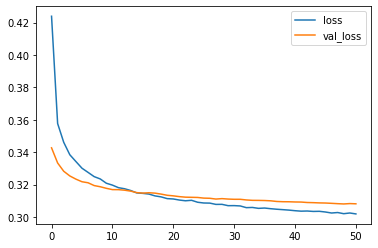

In [58]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [59]:

from sklearn.metrics import classification_report, confusion_matrix


test_pred = model.predict_classes(test_inputs)

print('\n'+classification_report(test_targets, test_pred))


              precision    recall  f1-score   support

           0       0.68      0.62      0.65      7752
           1       0.91      0.93      0.92     31769

    accuracy                           0.87     39521
   macro avg       0.79      0.77      0.78     39521
weighted avg       0.86      0.87      0.87     39521



In [60]:
confusion_matrix(test_targets, test_pred)

array([[ 4810,  2942],
       [ 2285, 29484]])

**We achieved an overall accuracy of 87%, but the overall f1-score for the minority class, i.e customers who won't payoff the loan is a bit low. 
The precision is near about 60% and the recall is around 70% . This is a fine trade-off as we will predict more charged-off borrowers, which is our goal.** 

#      